# Progetto Deep Learning GAN

In questo notebook verrà illustrato come è stato ottenuto il modello generativo (GAN) che verrà utilizzato per generare gatti o cani sintetici nei notebook successivi.





## Come funziona una GAN
Le reti avversarie generative (Generative Adversaries Network), fanno parte dei così detti modelli generativi. Le GAN creano nuove istanze di dati simili ai dati di addestramento. Nell’esempio preso in considerazione in questo progetto, le GAN sono state utilizzate per andare a creare nuove immagini che assomigliano a fotografie di animali (Cani o Gatti).
Questa tipologia di modelli generativi riesce a raggiungere un buon livello di realismo lavorando contemporaneamente su due modelli: un modello generatore e un modello discriminatore. Il modello generatore avrà il compito di andare a produrre l’output di destinazione, a sua volta il discriminatore dovrà imparare a distinguere i dati reali dall’output del generatore.

### Anatomia di una GAN

Una rete avversaria generativa (GAN) si compone di due parti:
* Il generatore impara a generare dati plausibili. Le istanze generate diventano esempi di addestramento negativi per il discriminatore.

* Il discriminatore impara a distinguere i dati falsi dal generatore da dati reali. Il discriminatore penalizza il generatore per la produzione di risultati non plausibili.

gan_diagram.svg


I modelli basati su reti avversarie generative sono più semplicemente applicabili quando i modelli sono entrambi perceptrons multilivello. Per imparare la distribuzione del generatore pg su un insieme di dati x, dovremo definire precedentemente una distribuzione di variabili che consisteranno in un tensore di rumore casuale pz(z), il quale verrà dato in pasto al generatore come input. Quindi andremo a rappresentare una mappatura dello spazio dei dati come G(z,g), dove G è una funzione differenziabile rappresentata da un perceptron multistrato con parametri g. Definiamo anche un secondo perceptron multistrato D(x,d) che produce uno scalare singolo. D(x) rappresenta la probabilità che x provenga dai dati reali, anziché dalla distribuzione pg. Alleniamo D per massimizzare la probabilità di assegnare l’etichetta corretta sia agli esempi di addestramento che ci campioni di G. Alleniamo contemporaneamente G per minimizzare log(1-D(G(z))). In altre parole su D e G verrà applicata la seguente funzione di loss V(G,D). Essa rappresenta la funzione valore che misura il gioco minmax tra il discriminatore D e il generatore G.

$$\min_G \max_D V(G,D) = \mathbb{E}{xP{data}}[\log D(x)] + \mathbb{E}_{zP_z(Z)}[\log(1-D(G(z)))
]$$





## Caricamento del dataset e import librerie

In [ ]:
!pip install git+https://github.com/tensorflow/docs
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from IPython import display
import tensorflow_docs.vis.embed as embed
from numpy import zeros
from numpy import ones
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import ReLU
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import UpSampling2D
from matplotlib import pyplot
from keras.initializers import RandomNormal
from keras import Sequential
from keras import backend as K
from keras import initializers
from keras.utils import conv_utils


  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-hdmujqj9
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-hdmujqj9
  Resolved https://github.com/tensorflow/docs to commit 40881b6e9c65d3cd164b391de055aeb60d2f51af
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2023.5.26.9808-py3-none-any.whl size=183623 sha256=d2aaa9224210ea27b87c0b29114fe3ad600a1b3676868c9c3008591cadb4da55
  Stored in directory: /tmp/pip-ephem-wheel-cache-56xcx5yq/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


Montiamo un account google drive, sul quale verranno salvati i risultati intermedi durante l'addestramento (checkpoints).

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


Scarichiamo il dataset scelto direttamente da kaggle ed effettuiamo la decompressione con il comando

```
!unzip -q kagglecatsanddogs_5340.zip

```



In [ ]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!unzip -q kagglecatsanddogs_5340.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   174M      0  0:00:04  0:00:04 --:--:--  174M


Dopo aver caricato il dataset direttamente su colab verrà richiamata una funzione di pre-processing, che permette di eliminare tutte le 1590 immagini corrotte che erano contenute nel dataset grezzo.

* La funzione sottostante è stata implementata utilizzando come base il codice presente nel seguente articolo: https://keras.io/examples/vision/image_classification_from_scratch/

In [ ]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1 # cancella le immagini corrotte
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


Dopo aver effettuato il pre-processing necessario il dataset viene caricato, utilizzando accorgimenti essenziali:
 * label_mode = None, permette di non considerare le label del dataset. Dato che stiamo andando a risolvere un problema non supervisionato esse non sono necessarie.
 * image_size=(64,64), tutte le immagini del dataset saranno scalate per essere 64 x 64, facilitando l'addestramento. L'utilizzare delle immagini troppo grandi avrebbe notevolmente allungato i tempi e i costi necessari per l'addestramento

In [ ]:
animalToGenerate ='Cat' # Qui puoi decidere se generare Cani o Gatti rispettivamente inserire "Cat" o "Dog"

In [ ]:
dataset = tf.keras.utils.image_dataset_from_directory('PetImages/' + animalToGenerate, label_mode=None, image_size=(64, 64), batch_size=32, smart_resize=True)

Found 11741 files belonging to 1 classes.


Scaliamo i valori tra, questa
è una best practice quando si lavora con le GAN.

In [ ]:
dataset = dataset.map(lambda x: x / 255.)

### Iperparametri
Durante lo svolgimento di questo progetto gran parte dei risultati sono stati ottenuti tramite il tuning degli iperparametri. Quando si lavora con dei modelli generativi proprio questo tuning risulta vitale per i dati che vengono generati (se ci si riferisce ad un'applicazione simile a quella presente in questo notebook). Nel blocco di codice sottostante è presente un'intera lista di iperparametri. Essi sono stati principalmente raccolti da articoli di ricerca e da qualche esperimento svolto dal team per affinarli.

In [ ]:
#Hyperparameters
batch_size = 64 # Dimensione dei batch
weight_init_std = 0.02 # Deviazione standard dei pesi iniziali, sembra da ricerche che stabilizza l'addestramento
weight_init_mean = 0.0 # Media dei pesi iniziali, sembra da ricerche che stabilizza l'addestramento
leaky_relu_slope = 0.2 # Un valore del genere sembra stabilizzi l'apprendimento
downsize_factor = 2 # Per fare in modo che possiamo fare il reshape del rumore a (4, 4, 512)
dropout_rate = 0.5
scale_factor = 4 ** downsize_factor # Per fare in modo che possiamo fare il reshape del rumore a (4, 4, 512)
lr_initial_d = tf.Variable(0.0002) # learning rate discriminatore
lr_initial_g = tf.Variable(0.0002) # learning rate generatore
noise_dim = 128 # Dimensione rumore, di solito si usa 128 o 100 che sembrano bastare, tuttavia ho deciso di usare 300.

#Image parameters
image_width = 64
image_height = 64
image_channels = 3 # rgb

# Loss lists
gen_loss_list = []
disc_loss_list = []

#Ceckpoints Directory
checkpoint_dir = '/content/drive/MyDrive/training_checkpoints_Dogs64_21'

Per controllare se il dataset è stato caricato nella maniera corretta e le immagini non sono corrotte viene visualizzata un'istanza del dataset.


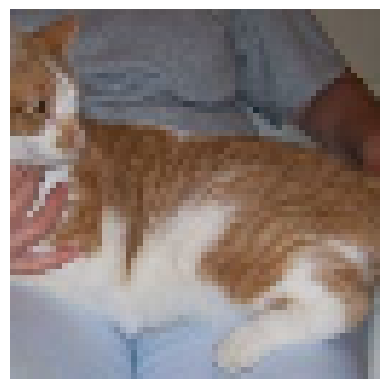

In [ ]:
for x in dataset:
  plt.axis("off")
  plt.imshow((x.numpy() * 255).astype("int32")[0])
  break

## Costruiamo un modello discriminatore e un modello generatore

### Inizializzazione dei Pesi
 Risulta essere piuttosto importante per addestrare GAN stabili. Innanzitutto, i pesi del modello devono essere centrati su zero con un lieve aumento della deviazione standard (0.02). Questo stabilizza sia il D (discriminatore) che il G (generatore) durante l'addestramento e impedisce che i gradienti del modello svaniscano o esplodano. Questo è un passaggio fondamentale in ogni caso in cui dobbiamo utilizzare variabili casuali nel nostro modello (come il vettore di rumore casuale).

Ecco un esempio di come l'inizializzazione dei pesi possa influenzare seriamente il processo di apprendimento di una rete neurale.
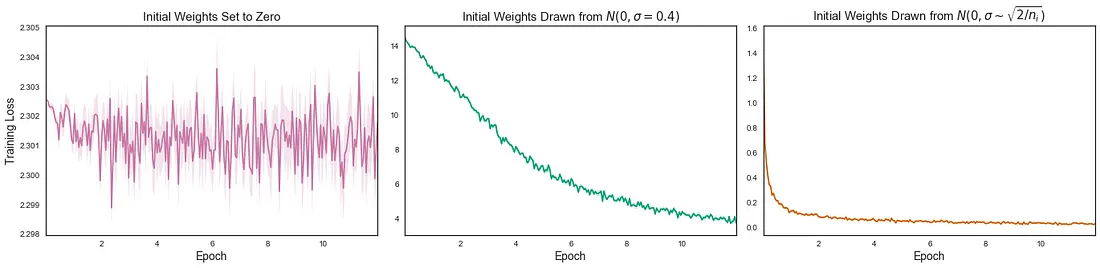

Possiamo anche applicare una distribuzione normale troncata (Truncated Normal) utilizzando Keras, che scarterà i valori che si discostano di più di 2 deviazioni standard dalla media. Questo potrebbe eliminare alcuni punti anomali durante l'addestramento.

* L'immagine sovrastante è stata ripresa dal seguente articolo https://towardsdatascience.com/dcgans-generating-dog-images-with-tensorflow-and-keras-fb51a1071432

In [ ]:
weight_initializer = tf.keras.initializers.TruncatedNormal(stddev=weight_init_std, mean=weight_init_mean,seed=42)

### Spectral Normalization
La normalizzazione Spettrale (Spectral Normalization) è una è una tecnica di inizializzazione dei pesi ideata specificatamente per le GAN che sembra stabilizzi l'addestramento. La normalizzazione spettrale di un singolo peso è definita come:

---

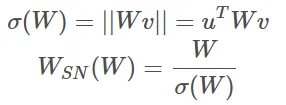

Qui, u e v sono semplici vettori casuali della stessa dimensione. Vengono utilizzati per eseguire quella che viene chiamata un'operazione di iterazione di potenza sul peso specifico, per ogni passaggio di apprendimento, e si dimostra essere molto più efficiente dal punto di vista computazionale rispetto a penalizzare semplicemente i gradienti.

Successivamente, nella fase di backpropagation, utilizziamo WSN(W) per aggiornare i pesi anziché W.


Qui viene presentato un esempio molto rappresentativo degli effetti della Spectral Normalization.
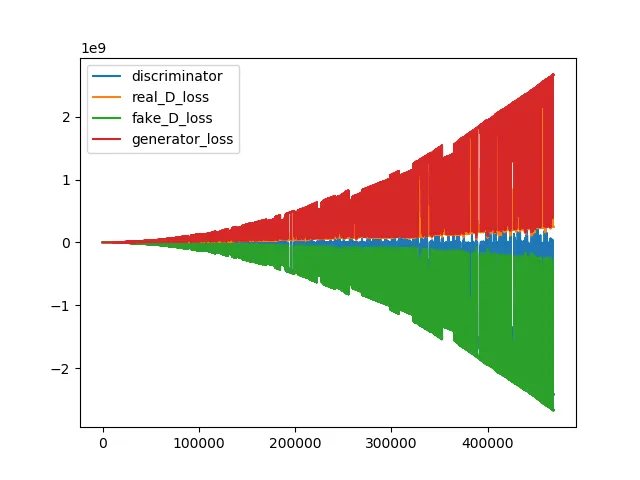

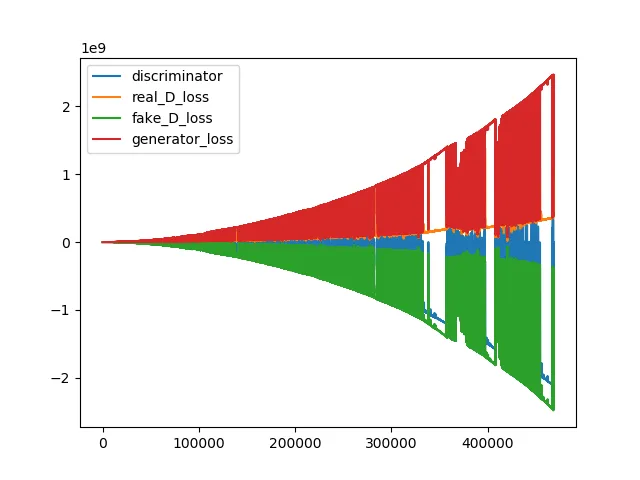


Nella prima immagine la Spectral Normalization viene utilizzata, mentre nella seconda no.

Gli elementi con cui è stata spiegata la normalizzazione spettrale e il codice necessario per la sua implementazione sono stati ripresi dai seguenti articoli:
* https://towardsdatascience.com/dcgans-generating-dog-images-with-tensorflow-and-keras-fb51a1071432
* https://github.com/IShengFang/SpectralNormalizationKeras/tree/master
* https://arxiv.org/pdf/1802.05957.pdf
* https://github.com/thisisiron/spectral_normalization-tf2
* https://www.tensorflow.org/addons/api_docs/python/tfa/layers/SpectralNormalization


Il codice fornito nel blocco di codice sottostante è un'implementazione personalizzata dei layer Dense e Conv2D in TensorFlow con normalizzazione spettrale. La normalizzazione spettrale è una tecnica utilizzata per stabilizzare l'addestramento delle GAN (Generative Adversarial Networks) limitando la costante di Lipschitz del layer tramite la limitazione della sua norma spettrale.

Il metodo build delle due classi inizializza i pesi e i bias del layer e crea una variabile u di forma (1, units) inizializzata con valori casuali distribuiti normalmente. Il metodo call della classe esegue la normalizzazione spettrale dei pesi e dei bias del layer calcolando la norma spettrale del tensore dei pesi e normalizzandola. Successivamente, applica i pesi normalizzati al tensore di input e aggiunge il termine di bias se use_bias è True. Infine, applica la funzione di attivazione al tensore di output e lo restituisce.

La funzione power_iteration viene utilizzata per calcolare il valore singolare più grande del tensore dei pesi utilizzando il metodo delle iterazioni di potenza. La funzione _l2normalize viene utilizzata per normalizzare il tensore di input alla lunghezza unitaria. La variabile sigma rappresenta il valore singolare più grande del tensore dei pesi, che viene utilizzato per normalizzare il tensore dei pesi. La variabile W_bar rappresenta il tensore dei pesi normalizzato.

Ecco una breve spiegazione delle variabili utilizzate nel codice:
* self.kernel: il tensore dei pesi del layer.
* self.bias: il tensore di bias del layer.
* self.u: una variabile di forma (1, units) inizializzata con valori casuali distribuiti normalmente.
* inputs: il tensore di input del layer.
* sigma: il valore singolare più grande del tensore dei pesi.
* W_bar: il tensore dei pesi normalizzato.

In [ ]:
class DenseSN(Dense):
    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]
        # Inizializza i pesi del livello DenseSN
        self.kernel = self.add_weight(shape=(input_dim, self.units),
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        # Aggiunge il peso u per la normalizzazione spettrale
        self.u = self.add_weight(shape=tuplex([1, self.kernel.shape.as_list()[-1]]),
                                 initializer=initializers.RandomNormal(0, 1),
                                 name='sn',
                                 trainable=False)
        self.input_spec = tf.keras.layers.InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True

    def call(self, inputs, training=None):
        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)

        def power_iteration(W, u):
          # Calcoliamo il valore singolare più grande del tensore dei pesi
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v

        W_shape = self.kernel.shape.as_list()
        # Applica la normalizzazione spettrale al tensore dei pesi
        W_reshaped = K.reshape(self.kernel, [-1, W_shape[-1]])
        _u, _v = power_iteration(W_reshaped, self.u)
        # Calcola Sigma
        sigma = K.dot(_v, W_reshaped)
        sigma = K.dot(sigma, K.transpose(_u))
        # Normalizza i pesi
        W_bar = W_reshaped / sigma
        # Reshape del tensore dei pesi
        if training in {0, False}:
            W_bar = K.reshape(W_bar, W_shape)
        else:
            with tf.control_dependencies([self.u.assign(_u)]):
                W_bar = K.reshape(W_bar, W_shape)

        output = K.dot(inputs, W_bar)
        if self.use_bias:
            output = K.bias_add(output, self.bias, data_format='channels_last')
        if self.activation is not None:
            output = self.activation(output)
        return output


class ConvSN2D(Conv2D):
    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (input_dim, self.filters)
        # Inizializza i pesi del livello Conv2D
        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)

        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None

        self.u = self.add_weight(shape=tuple([1, self.kernel.shape.as_list()[-1]]),
                                 initializer=initializers.RandomNormal(0, 1),
                                 name='sn',
                                 trainable=False)

        self.input_spec = tf.keras.layers.InputSpec(ndim=self.rank + 2,
                                                    axes={channel_axis: input_dim})
        self.built = True

    def call(self, inputs, training=None):
        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)

        def power_iteration(W, u):
           # Calcoliamo il valore singolare più grande del tensore dei pesi
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v

        W_shape = self.kernel.shape.as_list()
        # Applica la normalizzazione spettrale al tensore dei pesi
        W_reshaped = K.reshape(self.kernel, [-1, W_shape[-1]])
        _u, _v = power_iteration(W_reshaped, self.u)
        # Calcola Sigma
        sigma = K.dot(_v, W_reshaped)
        sigma = K.dot(sigma, K.transpose(_u))
        # Normalizza i pesi
        W_bar = W_reshaped / sigma
        # Reshape del tensore dei pesi
        if training in {0, False}:
            W_bar = K.reshape(W_bar, W_shape)
        else:
            with tf.control_dependencies([self.u.assign(_u)]):
                W_bar = K.reshape(W_bar, W_shape)

        outputs = K.conv2d(
            inputs,
            W_bar,
            strides=self.strides,
            padding=self.padding,
            data_format=self.data_format,
            dilation_rate=self.dilation_rate)
        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)
        if self.activation is not None:
            return self.activation(outputs)
        return outputs


Creiamo dei Template per creare in maniera più semplice il nostro generatore e discriminatore. Ossia creiamo delle funzioni che ne richiamano altre per creare dei blocchi

In [ ]:
def transposed_conv(model, out_channels, ksize, stride_size, ptype='same'):
    model.add(Conv2DTranspose(out_channels, (ksize, ksize),
                              strides=(stride_size, stride_size), padding=ptype,
                              kernel_initializer=weight_initializer, use_bias=False))
    model.add(BatchNormalization())
    model.add(ReLU())
    return model

def convSN(model, out_channels, ksize, stride_size):
    model.add(ConvSN2D(out_channels, (ksize, ksize), strides=(stride_size, stride_size), padding='same',
                     kernel_initializer=weight_initializer, use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=leaky_relu_slope))
    model.add(Dropout(dropout_rate))
    return model

def conv(model, out_channels, ksize, stride_size):
    model.add(Conv2D(out_channels, (ksize, ksize), strides=(stride_size, stride_size), padding='same',
                     kernel_initializer=weight_initializer, use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=leaky_relu_slope))
    model.add(Dropout(dropout_rate))
    return model

### Generatore
Creiamo la funzione che ci permette di richiamare i template definiti sopra per ottenere il nostro modello generatore.

In [ ]:
def AnimalGenerator():
		model = Sequential()
		model.add(Dense(image_width // scale_factor * image_height // scale_factor * 128,
								input_shape=(noise_dim,), kernel_initializer=weight_initializer))
		model.add(Reshape((image_height // scale_factor, image_width // scale_factor, 128)))

		model = transposed_conv(model, 512, ksize=5, stride_size=1)
		model.add(Dropout(dropout_rate))
		model = transposed_conv(model, 256, ksize=5, stride_size=2)
		model.add(Dropout(dropout_rate))
		model = transposed_conv(model, 128, ksize=5, stride_size=2)
		model = transposed_conv(model, 64, ksize=5, stride_size=2)
		model = transposed_conv(model, 32, ksize=5, stride_size=2)

		model.add(Dense(3, activation='tanh', kernel_initializer=weight_initializer))


		return model

generator = AnimalGenerator()
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 2048)              264192    
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 4, 4, 512)        1638400   
 ranspose)                                                       
                                                                 
 batch_normalization_8 (Batc  (None, 4, 4, 512)        2048      
 hNormalization)                                                 
                                                                 
 re_lu_5 (ReLU)              (None, 4, 4, 512)         0         
                                                                 
 dropout_5 (Dropout)         (None, 4, 4, 512)        

### Discriminatore
Creiamo la funzione che ci permette di richiamare i template definiti sopra per ottenere il nostro modello discriminatore.

In [ ]:
def AnimalDiscriminator(spectral_normalization=True):
				model = Sequential()
				model.add(ConvSN2D(64, (5, 5), strides=(1,1), padding='same', use_bias=False,
											input_shape=[image_height, image_width, image_channels],
											kernel_initializer=weight_initializer))

				model.add(LeakyReLU(alpha=leaky_relu_slope))
				model = convSN(model, 64, ksize=5, stride_size=2)
				model.add(LeakyReLU(alpha=leaky_relu_slope))
				model = convSN(model, 128, ksize=5, stride_size=2)
				model = convSN(model, 256, ksize=5, stride_size=2)

				model.add(Flatten())
				model.add(DenseSN(1, activation='sigmoid'))
				return model

discriminator = AnimalDiscriminator()
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_sn2d_4 (ConvSN2D)      (None, 64, 64, 64)        4864      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                                 
 conv_sn2d_5 (ConvSN2D)      (None, 32, 32, 64)        102464    
                                                                 
 batch_normalization_13 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 dropout_7 (Dropout)         (None, 32, 32, 64)        0         
                                                      

Istanziamo la funzione per il calcolo delle loss e un array di 16 vettori per visionare la qualità delle immagini generate durante l'addestramento, utilizzando una funzione di visualizzazione apposita.

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()
seed = tf.random.normal([16, noise_dim])

Funzioni di Loss

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Istanziamo gli optimizer per entrambi i modelli utilizzando parte degli iperparametri definiti precedentemente

In [ ]:
generator_optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=lr_initial_g, beta1=0.5)
discriminator_optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=lr_initial_d, beta1=0.5)

Definiamo la funzione necessaria per eseguire un singolo ciclo di addestramento. Questa funzione esegue divere azioni:
* Genera del rumore casuale, in base al noise_dim e al BATCH_SIZE necessario per l'assestramento di entrambi i modelli.

* Genera delle immagini passando il vettore di rumore al generatore.
* Ottiene tramite il discriminatore le label di classificazione per le immagini originali e per quelle generate.
* Attraverso la funzione di loss definita precedentemente vengono calcolate le loss dei due modelli
* Utilizzando le due loss vengono aggiornati i pesi del generatore e del discriminatore

Questo blocco di codice, come i 2 successivi sono stati presi dalle lezioni laboratorio del corso Deep Learning, tenuto dal professore Mirko Marras per i ragazzi appartenenti al secondo anno della laurea triennale in Informatica Applicata e Data Analytics presso l'università degli studi di Cagliari.

In [ ]:
@tf.function
def train_step(images):
    # Generiamo un array di rumore casuale per ogni immagine nel batch
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    # Instanziamo i due GradientTape (uno per il generatore e uno per il discriminatore)
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      # Generiamo le immagini partendo dal rumore casuale
      generated_images = generator(noise, training=True)
      print(generated_images.shape)
      # Otteniamo (tramite il discriminatore)le label di classificazione per le immagini originali e per quelle generate
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      # Misuriamo la loss del generatore (quanto è stato bravo a generare immagini credibili)
      gen_loss = generator_loss(fake_output)
      # Misuriamo la loss del discriminatore (quanto è stato bravo a capire quali immagini siano state generate artificialmente e quali no)
      disc_loss = discriminator_loss(real_output, fake_output)

    # Calcoliamo i gradienti per entrambi i modelli
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Aggiorniamo i pesi per entrambi i modelli
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss

Generiamo delle immagini che saranno utili per visualizzare le prestazioni e la capacità generativa del nostro modello durante l'addestramento

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notiamo il parametro "training=False". In questo step stiamo usando il modello in modalità inferenza.
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      np_img = predictions[i, :, :, :].numpy() * 255
      plt.imshow(np_img.astype(np.uint8))
      plt.axis('off')

  plt.savefig('faces_image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

Nel blocco sottostante è presente la vera e propria funzione di addestramento, la quale come prima cosa va a controllare se è possibile effettuare un reload di checkpoint che fanno parte di addestramenti precedenti. Nel caso in cui questa ricerca risulti negativa l'addestramento riprenderà da 0.

In [ ]:
# Define the checkpoint directory path
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Define the train function
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)

        # Produce the images for visualization during training
        display.clear_output(wait=True)
        gen_loss_list.append(gen_loss.numpy())
        disc_loss_list.append(disc_loss.numpy())
        print(f"Loss Generatore: {gen_loss}, Loss Discriminatore: {disc_loss}")
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)
        # Save the model as a checkpoint
        if (epoch + 1) % 40 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate the images at the end of training
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

# Restore the latest checkpoint
ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)
latest_checkpoint = ckpt_manager.latest_checkpoint
if latest_checkpoint:
    checkpoint.restore(latest_checkpoint)
    print("Latest checkpoint restored:", latest_checkpoint)
else:
    print("No checkpoint found. Starting from scratch.")


Latest checkpoint restored: /content/drive/MyDrive/training_checkpoints_Cats64_20/ckpt-12


In [ ]:
EPOCHS = 400
BATCH_SIZE = 64
train(dataset, EPOCHS)

## Note Finali
Il motivo per cui penso non riesca a generare dei cani accettabili, nonostante siano stati provati numerosi notebook ed altrettante architetture, penso sia dovuta alla scarsa qualità dei dati in quanto guardando qualche immagine del dataset ho notato come in molte immagini sono presenti soggetti esterni oltre il cane. Penso questo perchè siamo riusciti a generare gatti con successo mentre cani no.


